In [26]:
import sys
print(sys.executable)
print(sys.version)

C:\Users\mepri\SentimentAnalysis_Airlines\venv\Scripts\python.exe
3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


In [1]:
import os
print(os.getcwd())

C:\Users\mepri\SentimentAnalysis_Airlines\notebook


In [3]:
print(os.path.exists("../images"))

False


In [2]:
import sys
!{sys.executable} -m pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\mepri\SentimentAnalysis_Airlines\venv\Scripts\python.exe -m pip install --upgrade pip


In [64]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import OrdinalEncoder , StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
from sklearn.metrics import roc_auc_score,f1_score, precision_score, recall_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import Randomize

In [65]:
columns =  ['text' ,'sentiment']

df = pd.read_csv("../data/amazon_cells_labelled.txt" , sep='\\t', engine = 'python', names  = columns)

## Dataset Overview

In [66]:
print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"\nShape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nSentiment Count: {df['sentiment'].value_counts()}")

DATASET OVERVIEW

Shape: (1000, 2)

Missing values:
text         0
sentiment    0
dtype: int64

Data types:
text         object
sentiment     int64
dtype: object

Sentiment Count: sentiment
0    500
1    500
Name: count, dtype: int64


## Previewing the Dataset

In [67]:
df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


### For further EDA we need to add some features to the dataset

## Feature Engineering

In [68]:
df['text_length'] = df['text'].str.len()
df['word_count']  =  df["text"].str.split().str.len()

In [69]:
#positive_words = ["great", "excellent", "love", "amazing", "perfect"]
negative_words = ["bad", "worst", "waste", "junk", "disappointed", "hate", 
                 "cheap" , "difficult" , "defeats" , "unreliable" , "complained" , "awful"]

#df["pos_word_count"] = df["text"].str.lower().str.count("|".join(positive_words))
df["neg_word_count"] = df["text"].str.lower().str.count("|".join(negative_words))
df["all_caps_count"] = df["text"].str.findall(r"\b[A-Z]{2,}\b").str.len()


In [70]:
df['exclamations'] = df.text.apply(lambda x: x.count('!'))
#df['capital_letters'] = df.text.apply(lambda x: sum(1 for c in x if c.isupper()))
df["has_negation"] = (
    df["text"]
    .str.lower()
    .str.contains(r"\b(not|no|never|don\'t|doesn\'t|didn\'t|can\'t|won\'t)\b")
    .astype(int)
)

C:\Users\mepri\AppData\Local\Temp\ipykernel_34336\1436172305.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  .str.contains(r"\b(not|no|never|don\'t|doesn\'t|didn\'t|can\'t|won\'t)\b")


## EDA

## Text distribution

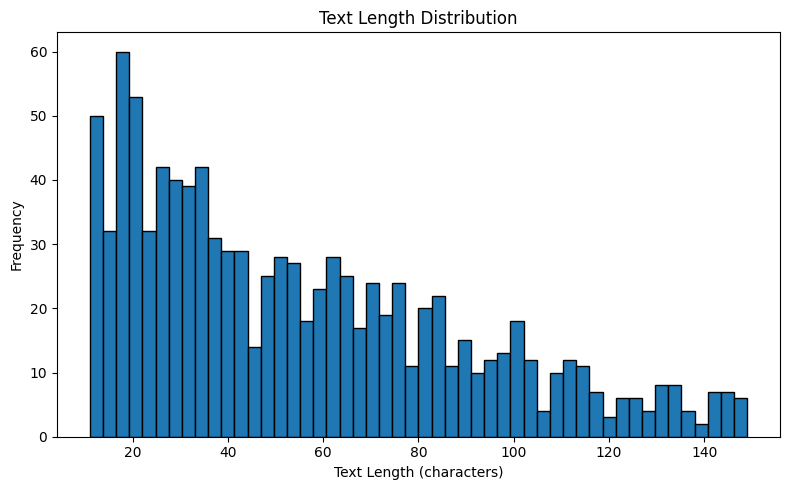

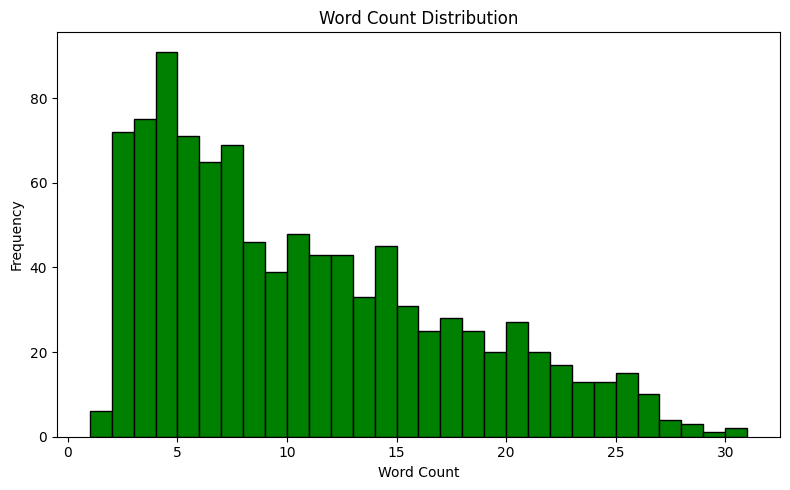

In [71]:
plt.figure(figsize=(8, 5))
plt.hist(df["text_length"], bins=50, edgecolor='black')
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.tight_layout()
plt.savefig('../images/text_length_distribution.png')
plt.show()

plt.figure(figsize=(8, 5))
max_len = df["word_count"].max()
plt.hist(
    df["word_count"],
    bins=np.arange(1, max_len + 2), edgecolor = 'black', color = 'green'
)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution")
plt.tight_layout()
plt.savefig('../images/word_count_distribution.png')
plt.show()









## EDA by Target Variable = Sentiment

In [72]:

df.groupby("sentiment")[["text_length", "word_count", "exclamations","neg_word_count","all_caps_count" ]].mean()

,text_length,word_count,exclamations,neg_word_count,all_caps_count
sentiment,,,,,
0,56.824,10.578,0.138,0.178,0.22
1,53.628,9.914,0.196,0.016,0.09


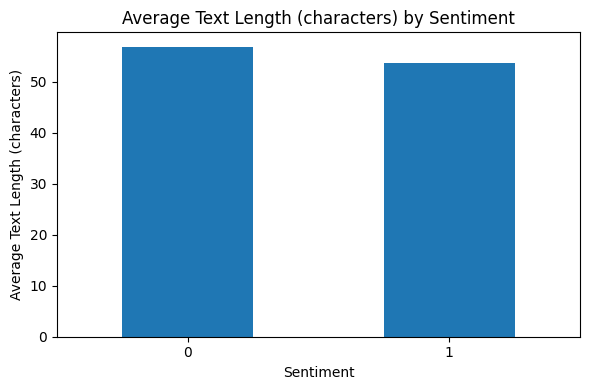

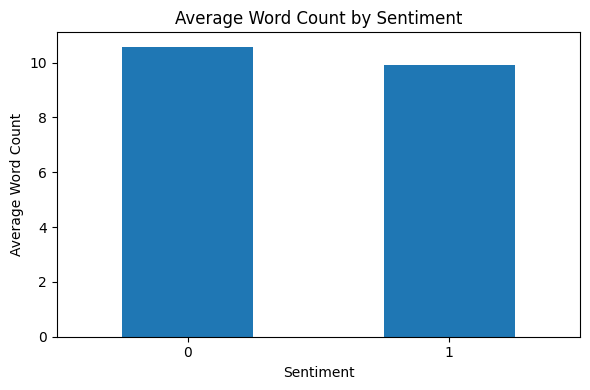

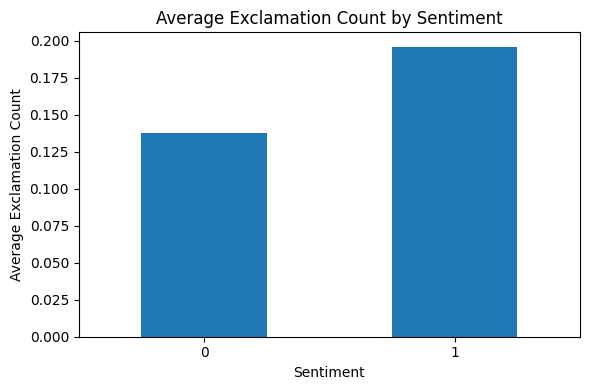

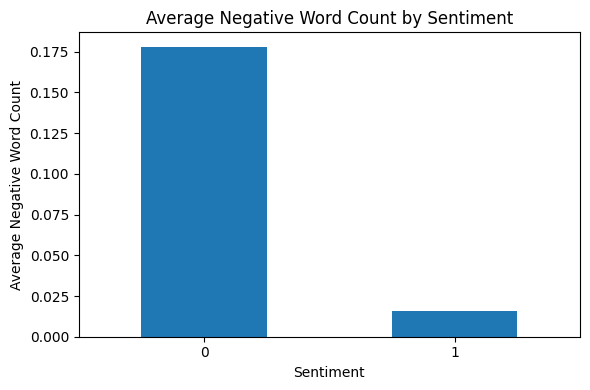

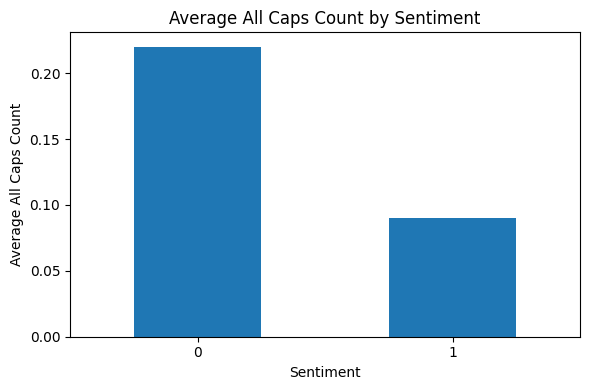

In [73]:



numeric_columns = [
    "text_length",
    "word_count",
    "exclamations",
    "neg_word_count",
    "all_caps_count"
]

label_map = {
    "text_length": "Text Length (characters)",
    "word_count": "Word Count",
    "exclamations": "Exclamation Count",
    "neg_word_count": "Negative Word Count",
    "all_caps_count": "All Caps Count"
}

for col in numeric_columns:
    means = df.groupby("sentiment")[col].mean()

    plt.figure(figsize=(6, 4))
    means.plot(kind="bar")

    plt.title(f"Average {label_map[col]} by Sentiment")
    plt.ylabel(f"Average {label_map[col]}")
    plt.xlabel("Sentiment")

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



CORRELATION ANALYSIS
                text_length  word_count  sentiment  exclamations  \
text_length        1.000000    0.977051  -0.046137     -0.064333   
word_count         0.977051    1.000000  -0.049669     -0.080677   
sentiment         -0.046137   -0.049669   1.000000      0.045451   
exclamations      -0.064333   -0.080677   0.045451      1.000000   
neg_word_count    -0.028661   -0.037192  -0.261985      0.004060   
all_caps_count     0.035266    0.030713  -0.080936      0.173909   

                neg_word_count  all_caps_count  
text_length          -0.028661        0.035266  
word_count           -0.037192        0.030713  
sentiment            -0.261985       -0.080936  
exclamations          0.004060        0.173909  
neg_word_count        1.000000        0.024023  
all_caps_count        0.024023        1.000000  


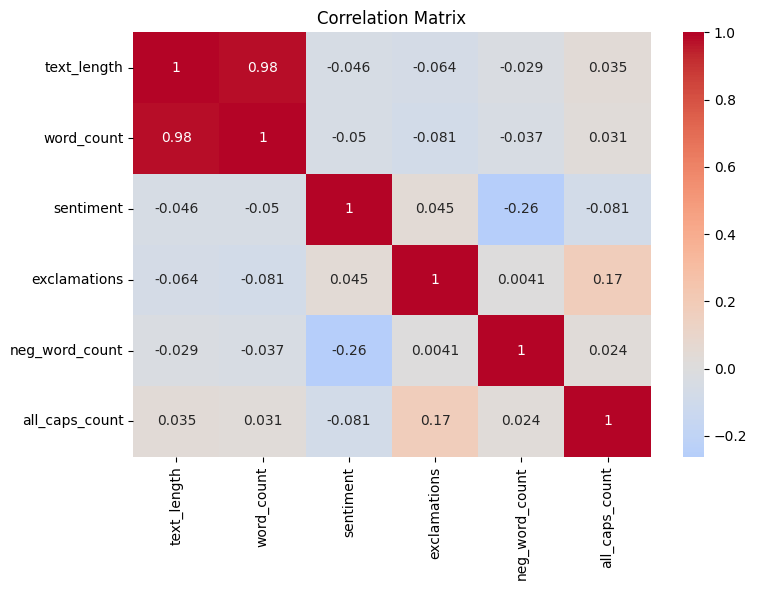

In [74]:
# 7. CORRELATION ANALYSIS
print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)
df[numeric_columns].corrwith(df.sentiment).abs().sort_values(ascending=False)
# Numeric features correlation
numeric_features = ['text_length', 'word_count', 'sentiment','exclamations', 'neg_word_count', 'all_caps_count']
correlation_matrix = df[numeric_features].corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('../images/correlation_matrix.png')
plt.show()


In [75]:
pd.crosstab(df["has_negation"], df["sentiment"], normalize="columns")

sentiment,0,1
has_negation,,
0,0.696,0.93
1,0.304,0.07


## Corpus Text Analysis


Top 20 most common words:
phone: 118
good: 66
great: 63
works: 43
battery: 39
sound: 35
one: 34
quality: 33
phone.: 33
would: 32
headset: 32
it.: 31
like: 30
use: 27
product: 27
really: 26
recommend: 24
work: 23
get: 22
excellent: 21

GENERATING WORD CLOUDS


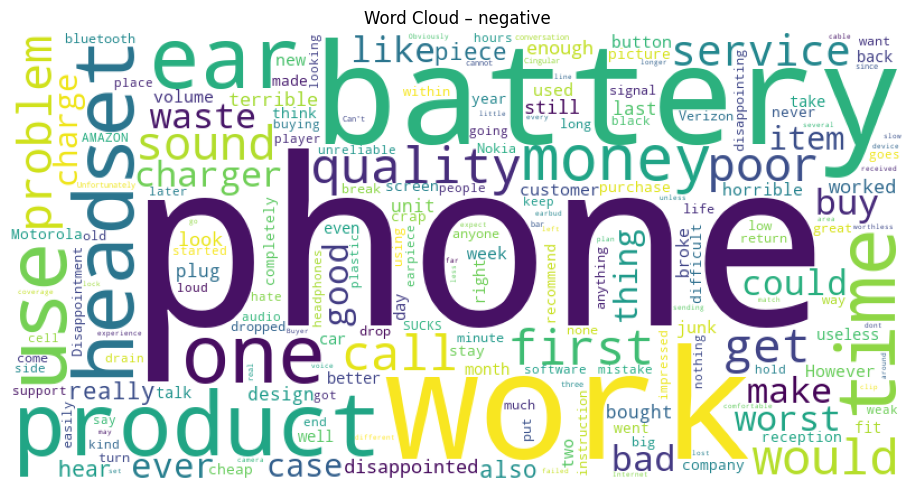


SAMPLE TEXTS BY EMOTION
  1. So there is no way for me to plug it in here in the US unless I go by a converter.
  2. Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
  3. I have to jiggle the plug to get it to line up right to get decent volume.
  1. Good case, Excellent value.
  2. Great for the jawbone.
  3. The mic is great.

EDA COMPLETE


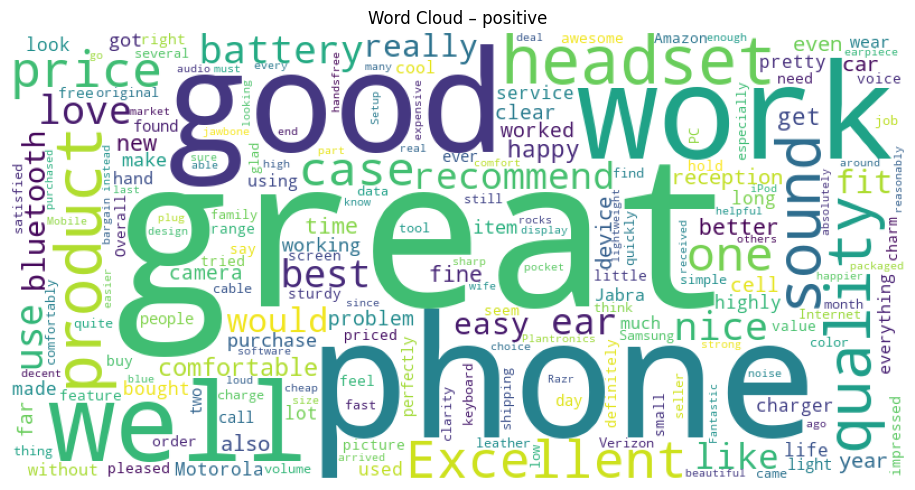


SAMPLE TEXTS BY EMOTION
  1. So there is no way for me to plug it in here in the US unless I go by a converter.
  2. Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
  3. I have to jiggle the plug to get it to line up right to get decent volume.
  1. Good case, Excellent value.
  2. Great for the jawbone.
  3. The mic is great.

EDA COMPLETE


In [76]:
# Get all words
all_text = ' '.join(df['text'].astype(str))
words = all_text.lower().split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
words_filtered = [word for word in words if word not in stop_words and len(word) > 2]

# Most common words
word_freq = Counter(words_filtered)
print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

# 5. WORD CLOUDS BY EMOTION
print("\n" + "="*50)
print("GENERATING WORD CLOUDS")
print("="*50)


for sentiment in df["sentiment"].unique():
    text_data = " ".join(
        df[df["sentiment"] == sentiment]["text"]
        .astype(str)
        .values
    )
 
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stop_words,
        #colormap=sentiment_colors.get(sentiment, "viridis"),
        max_words=200,
        collocations=False
    ).generate(text_data)

    if sentiment == 1: 
        label = 'positive'
    else:
        label = 'negative'
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud – {label}")
    plt.tight_layout()
    plt.savefig('../images/Word_Cloud_by_'+label+'_sentiment.png')
    plt.show()


    print("\n" + "="*50)
    print("SAMPLE TEXTS BY EMOTION")
    print("="*50)

    for sentiment in [0,1]:
        samples = df[df['sentiment'] == sentiment]['text'].head(3).tolist()
        for i, sample in enumerate(samples, 1):
            print(f"  {i}. {sample}")

    print("\n" + "="*50)
    print("EDA COMPLETE")
    print("="*50)

In [77]:
def _clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)   # remove urls
    text = re.sub(r"[^a-z\s!?]", "", text)          # keep ! and ?
    text = re.sub(r'\s+', ' ', text).strip()       # normalize whitespace

    return text

df['clean_text'] = df['text'].apply(_clean_text)

In [78]:
## Spliting 

In [91]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
y_train = df_train.sentiment.values
y_val = df_val.sentiment.values


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = df_train["clean_text"]

X_val = df_val['clean_text']


tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)


In [93]:
from scipy.sparse import hstack

numeric_features = [
    "text_length",
    "word_count",
    "exclamations",
    "neg_word_count",
    "all_caps_count",
    "has_negation"
]

X_num_train = df_train[numeric_features]
X_num_val   = df_val[numeric_features]

X_train_final = hstack([X_train_tfidf, X_num_train])
X_val_final   = hstack([X_val_tfidf, X_num_val])


## Logistic Regression Model

In [94]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="saga",
    n_jobs=-1
)


### Tuning Logistic Regression model for various Regularization (C) parameters

In [95]:
param_grid = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l1", "l2"]
}

In [96]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [97]:
grid_search.fit(X_train_final, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the

In [98]:
print("Best parameters:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Best parameters: {'C': 5, 'penalty': 'l2'}
Best CV F1: 0.7284522496114316


In [100]:
from sklearn.metrics import classification_report, confusion_matrix


y_val_pred = best_model.predict(X_val_final)

print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.88      0.58      0.70       108
           1       0.65      0.90      0.75        92

    accuracy                           0.73       200
   macro avg       0.76      0.74      0.73       200
weighted avg       0.77      0.73      0.73       200

[[63 45]
 [ 9 83]]


In [101]:
y_probs = best_model.predict_proba(X_val_final)[:, 1]


### Threshold Tuning of Logistic Regression Model

In [102]:
thresholds= np.linspace(0,1,21).round(2)
acc_scores = []
#print("threshold | accuracy score")
for t in thresholds:
    decision = (y_probs >=t)
    ### score = (y_val == loan_decision).mean()*100
    if decision.sum() == 0:
        print(f"t={t:.2f} → no positive predictions, skipped")
        continue
        
    acc_scores.append(
    {
        "Threshold": t,
        "Precision" : precision_score(y_val, decision,zero_division=0),
        "F1 Score" : f1_score(y_val, decision)
         }
    )


t=0.90 → no positive predictions, skipped
t=0.95 → no positive predictions, skipped
t=1.00 → no positive predictions, skipped


In [104]:
t_scores = pd.DataFrame(acc_scores)
t_scores

,Threshold,Precision,F1 Score
0,0.00,0.460000,0.630137
1,0.05,0.464286,0.631944
2,0.10,0.473958,0.640845
3,0.15,0.508380,0.671587
4,0.20,0.555556,0.708661
5,0.25,0.582781,0.724280
6,0.30,0.594595,0.733333
7,0.35,0.591837,0.728033
8,0.40,0.601399,0.731915
9,0.45,0.625000,0.745614


## For Logistic Regression best precision 
<b> The best F1 Score is acheived at threshold = 0.5, hence we will consider 0.5 as threshold . <br> LogisticRegression Model is giving F1 Score  of 0.754545 and Precision= 0.648438 on validation set. 

In [121]:
from sklearn.svm import LinearSVC

for C in [0.1, 0.5, 1, 2]:
    svm = LinearSVC(
    C=C,
    class_weight="balanced",
    random_state=42
    )

    svm.fit(X_train_final, y_train)
    y_pred = svm.predict(X_val_final)
    print(C, f1_score(y_val, y_pred))



0.1 0.7547169811320755
0.5 0.7526881720430108
1 0.7407407407407407
2 0.7301587301587301


## Best F1 score is obtained at C = 0.1 on the validation set Hence we will create best model

In [122]:
svm_best = LinearSVC(
    C=0.1,
    class_weight="balanced",
    random_state=42
    )
svm_best.fit(X_train_final, y_train)
y_pred_best = svm_best.predict(X_val_final)

In [123]:

print(classification_report(y_val, y_pred_best))
print(confusion_matrix(y_val, y_pred_best))


              precision    recall  f1-score   support

           0       0.85      0.63      0.72       108
           1       0.67      0.87      0.75        92

    accuracy                           0.74       200
   macro avg       0.76      0.75      0.74       200
weighted avg       0.77      0.74      0.74       200

[[68 40]
 [12 80]]


## For Linear SVC Model Precision = 0.85 for negative senitment and precision = 0.67 for positive sentiment. 

## Random Forest Classifier

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [136]:
n_estimators = [100, 200, 300]
max_features = ['sqrt', 'log2']
max_depth = [5, 10, 15]
min_samples_leaf = [10, 15, 20, 30, 50, 80, 100]

params_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

model_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

model_cv = GridSearchCV(
    estimator=model_rf,
    param_grid=params_grid,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1
)

model_cv.fit(X_train_final, y_train)

print("Best Parameters:", model_cv.best_params_)

best_model = model_cv.best_estimator_


Fitting 3 folds for each of 126 candidates, totalling 378 fits
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 300}


## After tuning best RF model has Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 300}


In [137]:
pred_forest = best_model.predict_proba(X_val_final)[:, 1]

In [138]:
thresholds = np.arange(0.1, 1, 0.05)
rf_threshold_metrics = []

for t in thresholds:
    decision = (pred_forest >= t).astype(int)

    f1 = f1_score(y_val, decision)
    prec =  precision_score(y_val, decision)
    rf_threshold_metrics.append([t, f1, prec])

rf_threshold_metrics = pd.DataFrame(
    rf_threshold_metrics, 
    columns=["Threshold", "F1", "Precision"]
)

print(rf_threshold_metrics)

    Threshold        F1  Precision
0        0.10  0.630137   0.460000
1        0.15  0.630137   0.460000
2        0.20  0.630137   0.460000
3        0.25  0.630137   0.460000
4        0.30  0.630137   0.460000
5        0.35  0.630137   0.460000
6        0.40  0.632302   0.462312
7        0.45  0.708661   0.555556
8        0.50  0.666667   0.753425
9        0.55  0.451613   0.875000
10       0.60  0.042553   1.000000
11       0.65  0.000000   0.000000
12       0.70  0.000000   0.000000
13       0.75  0.000000   0.000000
14       0.80  0.000000   0.000000
15       0.85  0.000000   0.000000
16       0.90  0.000000   0.000000
17       0.95  0.000000   0.000000


C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mepri\SentimentAnalysis_Airlines\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res